# Downloading the stanford cars dataset.

This notebook was developed as a response to the first assignment for the 2018 fast.ai deep learning course.  Most of the deep learning code is liberally copied from the notebooks from those courses.

## Load Data Set
First install the kaggle API.  Also had to configure my token using the methods described here: https://github.com/Kaggle/kaggle-api

In [1]:
!pip install kaggle


Download the stanford cars dateset into the paperspace persistence storage directory and automatically unzip it.  Note that I originally tried to use the data set on kaggle called the stanford-car-dataset, but eventually realized that the label meta data was corrupted, so I switched to using this data set instead.

In [2]:
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder -p /storage/stanford_cars_v2 --unzip

100%|#####################################9| 1.82G/1.82G [00:23<00:00, 90.9MB/s]
100%|######################################| 1.82G/1.82G [00:30<00:00, 63.6MB/s]


In [3]:
! ls /storage/stanford_cars_v2

anno_test.csv  anno_train.csv  car_data  car_data.zip  names.csv


In [4]:
! unzip -u -q /storage/stanford_cars_v2/car_data -d /storage/stanford_cars_v2

In [5]:
import pandas as pd
import numpy as np
from scipy.io import loadmat 
from pathlib import Path

In [6]:
datapath = Path('/storage/stanford_cars_v2/')

In [7]:
heading = ['filename','bboxx','bboyy','bboxwidth','bboxheight','classnum']
DF_test = pd.read_csv(datapath/'anno_test.csv',names=heading).assign(test=1).set_index('filename')
DF_train = pd.read_csv(datapath/'anno_train.csv',names=heading).assign(test=0).set_index('filename')
DF_test.head()

,bboxx,bboyy,bboxwidth,bboxheight,classnum,test
filename,,,,,,
00001.jpg,30,52,246,147,181,1
00002.jpg,100,19,576,203,103,1
00003.jpg,51,105,968,659,145,1
00004.jpg,67,84,581,407,187,1
00005.jpg,140,151,593,339,185,1


In [8]:
DF_Labels = pd.read_csv(datapath/'names.csv',names=['ClassName'])
DF_Labels.head()

,ClassName
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [9]:
DF_test=DF_test.assign(ClassName=DF_test.classnum.map(DF_Labels.ClassName))
DF_train=DF_train.assign(ClassName=DF_train.classnum.map(DF_Labels.ClassName))
DF_train.head()

,bboxx,bboyy,bboxwidth,bboxheight,classnum,test,ClassName
filename,,,,,,,
00001.jpg,39,116,569,375,14,0,Audi R8 Coupe 2012
00002.jpg,36,116,868,587,3,0,Acura TL Type-S 2008
00003.jpg,85,109,601,381,91,0,Dodge Magnum Wagon 2008
00004.jpg,621,393,1484,1096,134,0,Hyundai Elantra Sedan 2007
00005.jpg,14,36,133,99,106,0,Ford Mustang Convertible 2007


## Load data into fast.ai ImageDataBunch

In [10]:
from fastai import *
from fastai.vision import *
import os

Getting files and labels in arrays, we will use the 'from_lists' method of the ImageDataBunch.  There are seperate train and test sets in this dataset, but will only use the train data in this notebook, based on the original demo workbook.  I need to reseach more how the fast.ai libraries manage those splits.

In [11]:
imgpath = datapath/'car_data/train/'
train_files = list(imgpath.glob('*/*.jpg')) 
train_labels = [f.parent.name for f in train_files]

test_imgpath = datapath/'car_data/test/'
test_files = list(test_imgpath.glob('*/*.jpg')) 
test_labels = [f.parent.name for f in test_files]

In [31]:
data = ImageDataBunch.from_lists(imgpath, fnames=train_files, labels = train_labels, 
                                 ds_tfms=get_transforms(), size=224,bs=64)
data.normalize(imagenet_stats)

The data is normalized, but note that though bbox information is available for this data set, it is not used in this notebook.

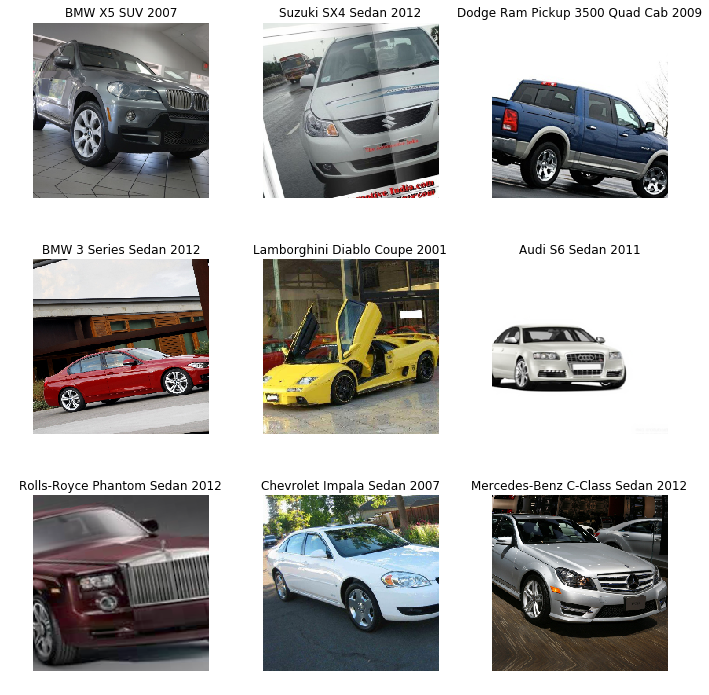

In [13]:
data.show_batch(rows=3, figsize=(10,10))

There are 196 classes in this data set.  They are multiple makes and models across a series of years.

In [14]:
len(data.classes),data.c

(196, 196)

## Training Resnet 34
First, the model is trained using ResNet 34 as a starting point, using the fit_one_cycle method.  The results are not very good, only reaching ~48% accuracy.

In [32]:
learn = ConvLearner(data, models.resnet34, metrics=error_rate)

In [16]:
learn.fit_one_cycle(4)

Total time: 02:49
epoch  train loss  valid loss  error_rate
1      5.131146    4.101665    0.869245    (00:43)
2      3.755335    2.895362    0.694291    (00:41)
3      2.761404    2.404782    0.583180    (00:43)
4      2.247010    2.312359    0.567219    (00:41)



In [17]:
learn.save('stage-1')

## Results

The following plots show the top 9 most inaccurate predictions.  Since my labels are so long, there is some overlap on the titles.  Regardless, what it shows is that the model is pretty confused.

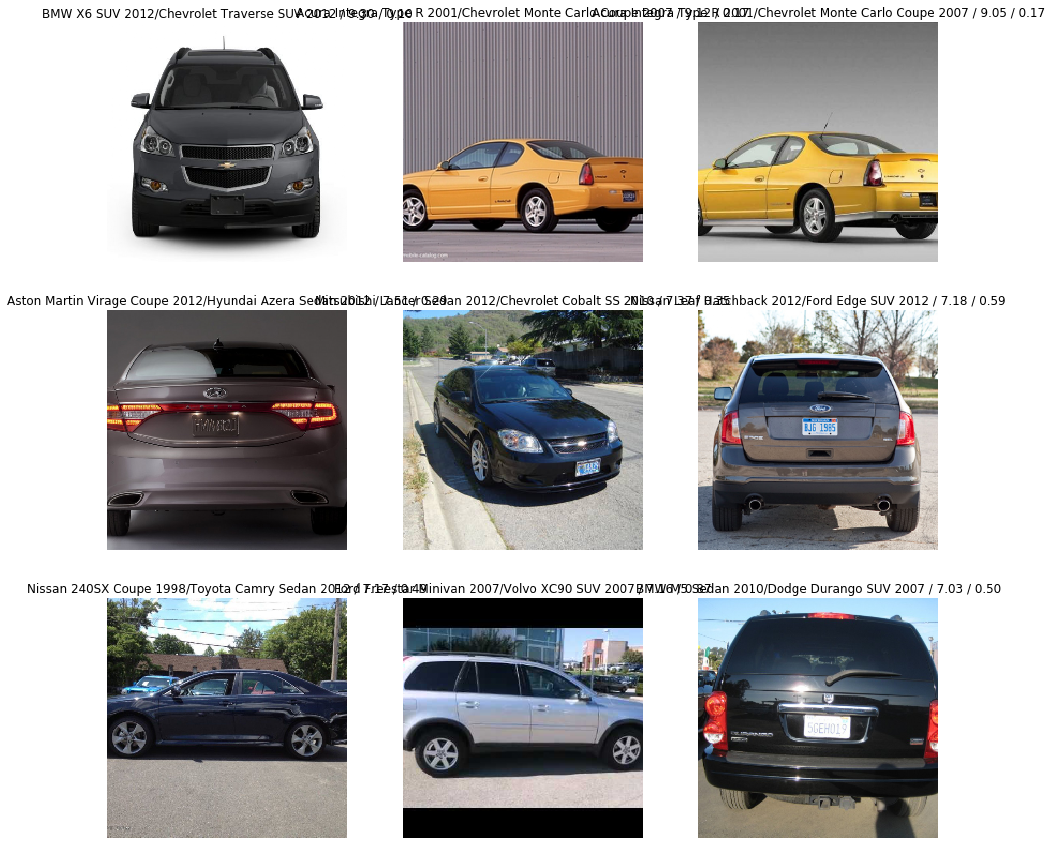

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_top_losses(9, figsize=(15,15))


Plotting the confusion matrix is not very helpful here, becuase there are so many classes.  Could be interesting to look at it across Manufacturer or something less detailed, but that is not persued at this time.

Looking at the most confused, the model does seem to get some traction, mostly confusing across model years, or model options, such as coupe vs convertible versions.

In [19]:
interp.most_confused(min_val=2)

[('Dodge Caliber Wagon 2012', 'Dodge Caliber Wagon 2007', 4),
 ('BMW ActiveHybrid 5 Sedan 2012', 'BMW 3 Series Wagon 2012', 4),
 ('GMC Savana Van 2012', 'Chevrolet Express Van 2007', 4),
 ('Ferrari 458 Italia Convertible 2012', 'Ferrari 458 Italia Coupe 2012', 4),
 ('Chevrolet Express Cargo Van 2007', 'Chevrolet Express Van 2007', 4),
 ('HUMMER H3T Crew Cab 2010', 'HUMMER H2 SUT Crew Cab 2009', 3),
 ('Audi S6 Sedan 2011', 'Audi S4 Sedan 2007', 3),
 ('Audi 100 Sedan 1994', 'Volvo 240 Sedan 1993', 3),
 ('Mercedes-Benz E-Class Sedan 2012', 'Mercedes-Benz S-Class Sedan 2012', 3),
 ('BMW 3 Series Sedan 2012', 'BMW X6 SUV 2012', 3),
 ('Dodge Caliber Wagon 2007', 'Dodge Caliber Wagon 2012', 3),
 ('Dodge Ram Pickup 3500 Quad Cab 2009',
  'Dodge Ram Pickup 3500 Crew Cab 2010',
  3),
 ('Audi RS 4 Convertible 2008', 'Audi S5 Convertible 2012', 3),
 ('BMW M6 Convertible 2010', 'BMW Z4 Convertible 2012', 3),
 ('Honda Accord Sedan 2012', 'Toyota Camry Sedan 2012', 3),
 ('Hyundai Sonata Sedan 2012', 

# Unfreeze
Since our model is working as we expect it to, we will unfreeze our model and train some more.

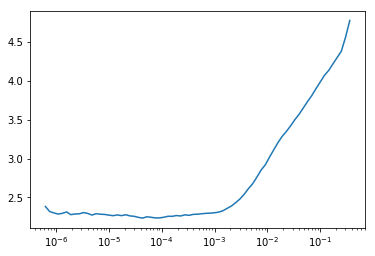

In [34]:
learn.load('stage-1')
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.load('stage-1')
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(10e-5,10e-3))

This actually works quite well, going from 48% to about 60% accuracy!

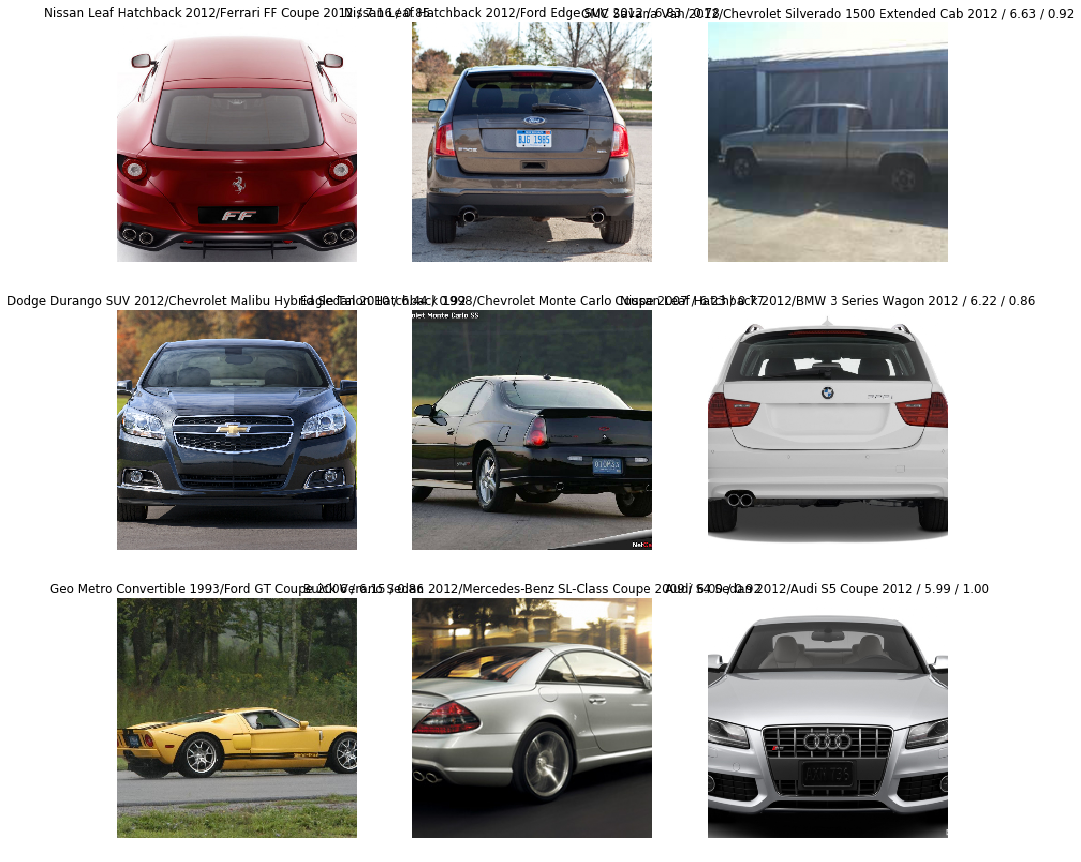

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_top_losses(9, figsize=(15,15))

## Train Resnet 50 Model
Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. Later in the course you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network might eat up our GPU memory.


In [23]:
data = ImageDataBunch.from_lists(imgpath, fnames=train_files, labels = train_labels, 
                                 ds_tfms=get_transforms(), size=320,bs=64//2)
data.normalize(imagenet_stats)

In [24]:
learn = ConvLearner(data, models.resnet50, metrics=error_rate)

In [25]:
learn.fit_one_cycle(8, max_lr=slice(1e-3))

Total time: 14:42
epoch  train loss  valid loss  error_rate
1      5.137753    4.448052    0.901434    (01:57)
2      3.953058    3.297935    0.706691    (01:49)
3      2.879035    2.377900    0.540621    (01:49)
4      2.090234    1.734077    0.396655    (01:48)
5      1.610016    1.446816    0.348268    (01:49)
6      1.207950    1.271585    0.320789    (01:48)
7      0.975856    1.208364    0.306452    (01:49)
8      0.942942    1.203419    0.307049    (01:49)



Trying the unfreeze with additional training, which gets the accuracy up to about 80%!

In [26]:
learn.save('stage-1-50')

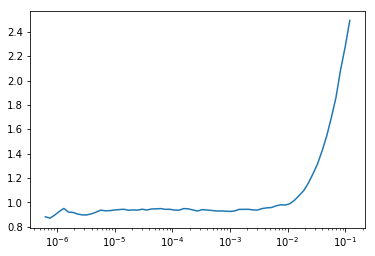

In [27]:
learn.load('stage-1-50')
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.load('stage-1-50')
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(10e-6,10e-4))

Total time: 07:03
epoch  train loss  valid loss  error_rate
1      1.190554    1.282046    0.347073    (02:22)
2      0.949470    0.806970    0.215054    (02:20)
3      0.464758    0.714402    0.194743    (02:20)



In [29]:
interp = ClassificationInterpretation.from_learner(learn)

interp.most_confused(min_val=2)

[('Audi S6 Sedan 2011', 'Audi S4 Sedan 2007', 7),
 ('Audi S4 Sedan 2012', 'Audi A5 Coupe 2012', 5),
 ('Chevrolet Express Van 2007', 'GMC Savana Van 2012', 4),
 ('Chevrolet Impala Sedan 2007', 'Chevrolet Malibu Sedan 2007', 3),
 ('Dodge Caliber Wagon 2012', 'Dodge Caliber Wagon 2007', 3),
 ('Audi TTS Coupe 2012', 'Audi TT Hatchback 2011', 3),
 ('Chevrolet Silverado 1500 Regular Cab 2012',
  'Chevrolet Silverado 2500HD Regular Cab 2012',
  3),
 ('Ford Mustang Convertible 2007', 'Chevrolet Camaro Convertible 2012', 3),
 ('HUMMER H2 SUT Crew Cab 2009', 'HUMMER H3T Crew Cab 2010', 3),
 ('Spyker C8 Coupe 2009', 'Spyker C8 Convertible 2009', 3),
 ('Chevrolet Silverado 1500 Extended Cab 2012',
  'Chevrolet Silverado 2500HD Regular Cab 2012',
  3),
 ('Chevrolet Express Van 2007', 'Chevrolet Express Cargo Van 2007', 3)]